In [144]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import toytree

import PIED

from collections import Counter

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

ipyclient = ipp.Client(cluster_id="cannabis")
len(ipyclient)

ntaxa = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## ClaDS return type

    list("tree"=obj,"times"=times,"nblineages"=nblineages,"rates"=rates,
    "lamb"=lamb,"mu"=mu,"maxRate"=tooHigh,"root_length"=root_length))

## Run one simulation to test behavior

In [145]:
%%R -i ntaxa -o res
res = sim_ClaDS(lambda_0=0.3, sigma_lamb=0.2, alpha_lamb=0.7, mu_0=0.5, taxa_stop=ntaxa, condition="taxa", prune_extinct=T)


## Run several simulations

In [182]:
%%R -i ntaxa -o times -o lamb -o mu
source("../sim_clads.R")
times = list()
lamb = list()
mu = list()

for (i in 1:50){
    r = sim_ClaDS(lambda_0=0.3, sigma_lamb=0.2, alpha_lamb=0.7, mu_0=0.5, taxa_stop=ntaxa, condition="taxa", prune_extinct=T)
    times[i] = r[2]
    lamb[i] = r[5]
    mu[i] = r[6]
    }

## Total time per simulation
As the last speciation event time

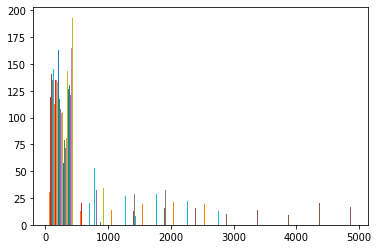

In [183]:
time = np.array(times)
time = [x[:-1] for x in time]
_ = plt.hist(time)

## Distributions of lambda and mu for ClaDS

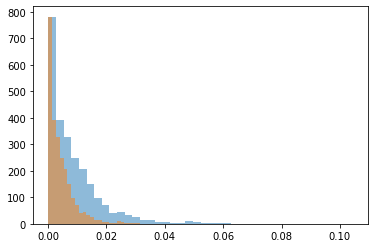

In [184]:
lamb = np.array(lamb)
mu = np.array(mu)
l = [item for sublist in lamb for item in sublist[-50:]]
m = [item for sublist in mu for item in sublist[-50:]]
_ = plt.hist(l, bins=40, alpha=0.5)
_ = plt.hist(m, bins=40, alpha=0.5)

# Compare to PIED

In [198]:
tree = PIED.Core("clads-horserace")
tree.set_param("ntaxa", 50)
tree.set_param("birth_rate", 0.3)
tree.set_param("process", "abundance")
tree.set_param("abundance_mean", 5e2)
tree.set_param("abundance_sigma", 0)
tree.set_param("growth_rate_mean", 5e-3)
tree.set_param("growth_rate_sigma", 5e-3)
tree.set_param("ClaDS", "True")
tree.set_param("ClaDS_sigma", 0.2)
tree.set_param("ClaDS_alpha", 0.7)
tree.set_param("sequence_length", 1000)
tree.set_param("mutation_rate", 1e-8)
tree.set_param("sample_size", 5)
_ = tree.get_params(verbose=True)

------- PIED params file (v.0.0.2)----------------------------------------------
clads-horserace      ## [0] [simulation_name]: The name of this simulation scenario
./default_PIED       ## [1] [project_dir]: Where to save files
0.3                  ## [2] [birth_rate]: Speciation rate
taxa                 ## [3] [stop_criterion]: Whether to stop on ntaxa or time
50                   ## [4] [ntaxa]: Number of taxa to simulate if stop is `ntaxa`
4                    ## [5] [time]: Amount of time to simulate if stop is `time`
abundance            ## [6] [process]: Whether to evolve `abundance` or growth `rate` via BM
True                 ## [7] [ClaDS]: Whether to allow speciation rates to change along the branches a la ClaDS
500                  ## [8] [abundance_mean]: Ancestral abundance at time 0
0.0                  ## [9] [abundance_sigma]: Rate at which abundance changes if process is `abundance`
0.005                ## [10] [growth_rate_mean]: Ancestral population growth rate at t

In [202]:
tree.simulate(nsims=50, ipyclient=ipyclient)

    Generating 50 simulation(s).
  [####################] 100%  Finished 50 simulations in   0:00:28| 
 {27: <Remote[20]:PIEDError(Failed inside serial_simulate:
cannot convert float NaN to integer)>, 42: <Remote[26]:PIEDError(Failed inside serial_simulate:
cannot convert float NaN to integer)>, 46: <Remote[12]:PIEDError(Failed inside serial_simulate:
cannot convert float NaN to integer)>}

   One or more simulations failed. Check PIED_log.txt for details.



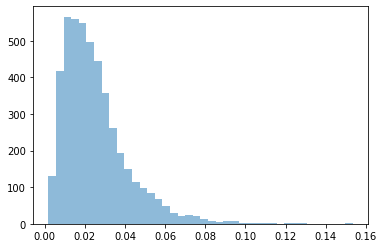

In [200]:
simfile = "/home/isaac/PIED/jupyter-notebooks/default_PIED/clads-horserace-SIMOUT.csv"
params, data = PIED.load_sims(simfile)
lambs = []
for idx, dat in data.iterrows():
    l = [x["lambda_"] for x in dat]
    lambs.extend(l)
_, _, _ = plt.hist(lambs, alpha=0.5, bins=40)

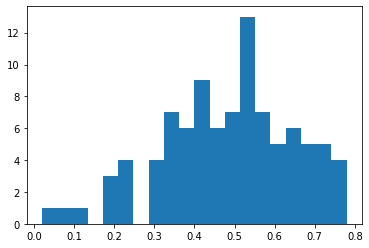

In [201]:
_ = plt.hist(params["turnover_rate"], bins=20)

## PIED Total time per simulation

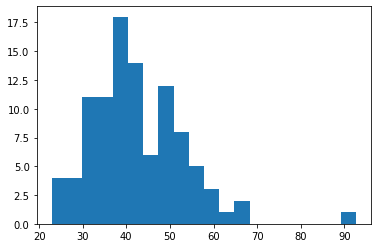

In [168]:
_ = plt.hist(params["obs_time"], bins=20)